In [10]:
from __future__ import print_function
from sshtunnel import SSHTunnelForwarder
import sys
import os
import configparser
import pandas as pd

working_path = os.path.abspath(os.path.join('.'))
if working_path.endswith('information-fostering'):
    working_path += '/notebooks'
sys.path.insert(1, working_path+'/../src/data')


# print(working_path)

import dbconnect
import seaborn as sns
import matplotlib.pyplot as plt


ini_path = working_path+'/../config.ini'
# dir_path = os.path.dirname(os.path.realpath(__file__))
#config_path = dir_path+'/../../config.ini'
config = configparser.ConfigParser()
config.read(ini_path)
(server,mysql_connection) = dbconnect.connect_with_config(ini_path)



def parse_problemhelp_entry(text):
    import re
    matches=re.findall(r'\"(.+?)\"',text)
    return(matches)

valid_userids = [int(u) for u in config['STUDY']['userids_valid'].split(',')]
problemhelp_df = pd.read_sql('''SELECT * FROM questionnaire_help_and_barriers''',mysql_connection)
problems = list(set([problem for (n,row) in problemhelp_df.iterrows() for problem in parse_problemhelp_entry(row['barriers'])]))
helps= list(set([help for (n,row) in problemhelp_df.iterrows() for help in parse_problemhelp_entry(row['help'])]))
stageid_to_task = {3:1,15:2,19:3}


print(valid_userids)
print(problems)
print(helps)

for p in problems:
    problemhelp_df[p] = problemhelp_df['barriers'].map(lambda x: p in parse_problemhelp_entry(x))
for h in helps:
    problemhelp_df[h] = problemhelp_df['help'].map(lambda x: h in parse_problemhelp_entry(x))
    
    
problems_unpacked_df = []
for (n,row) in problemhelp_df.iterrows():
    for p in problems:
        if row[p]:
            newrow = dict()
            for elem in problemhelp_df.columns.values:
                if (elem not in problems) and (elem not in helps):
                    newrow[elem] = row[elem]
            newrow['problem'] = p
            problems_unpacked_df += [newrow]
  
helps_unpacked_df = []          
for (n,row) in problemhelp_df.iterrows():
    for h in helps:
        if row[h]:
            newrow = dict()
            for elem in problemhelp_df.columns.values:
                if (elem not in problems) and (elem not in helps):
                    newrow[elem] = row[elem]
            newrow['help_single'] = h
            helps_unpacked_df += [newrow]

problems_unpacked_df = pd.DataFrame(problems_unpacked_df)
helps_unpacked_df = pd.DataFrame(helps_unpacked_df)

problems_unpacked_df = problems_unpacked_df[problems_unpacked_df['user_id'].isin(valid_userids)]
helps_unpacked_df = helps_unpacked_df[helps_unpacked_df['user_id'].isin(valid_userids)]
problemhelp_df = problemhelp_df[problemhelp_df['user_id'].isin(valid_userids)]




server.stop()

2018-12-12 22:06:25,509| ERROR   | Could not establish connection from ('127.0.0.1', 52592) to remote side of the tunnel


[37, 49, 59, 70, 94, 97, 101, 110, 112, 113, 116, 118, 119, 123, 125, 126, 127]
['irrelevant_results', 'source_unavailable', 'sources_unaware', 'patience_lack', 'topknowledge_lack', 'toomuch_information', 'no_problem', 'difficult_articulate', 'credibility_uncertain']
['no_help_needed', 'query_recommendation', 'page_recommendation', 'people_recommendation', 'strategy_recommendation', 'system_unsatisfactory']


In [2]:
# RQ1 - To what extent do the problems experienced and help required by users change 
# throughout a user’s search session?

In [3]:
# RQ 2 - Do behaviors differ as the problems experienced by users differ? 
# As the help required by users differs?

In [4]:
# RQ 3.1 - Do the problems experienced by users differ between tasks?

In [4]:
# RQ 3.2 - Do the helps required by users differ between tasks?

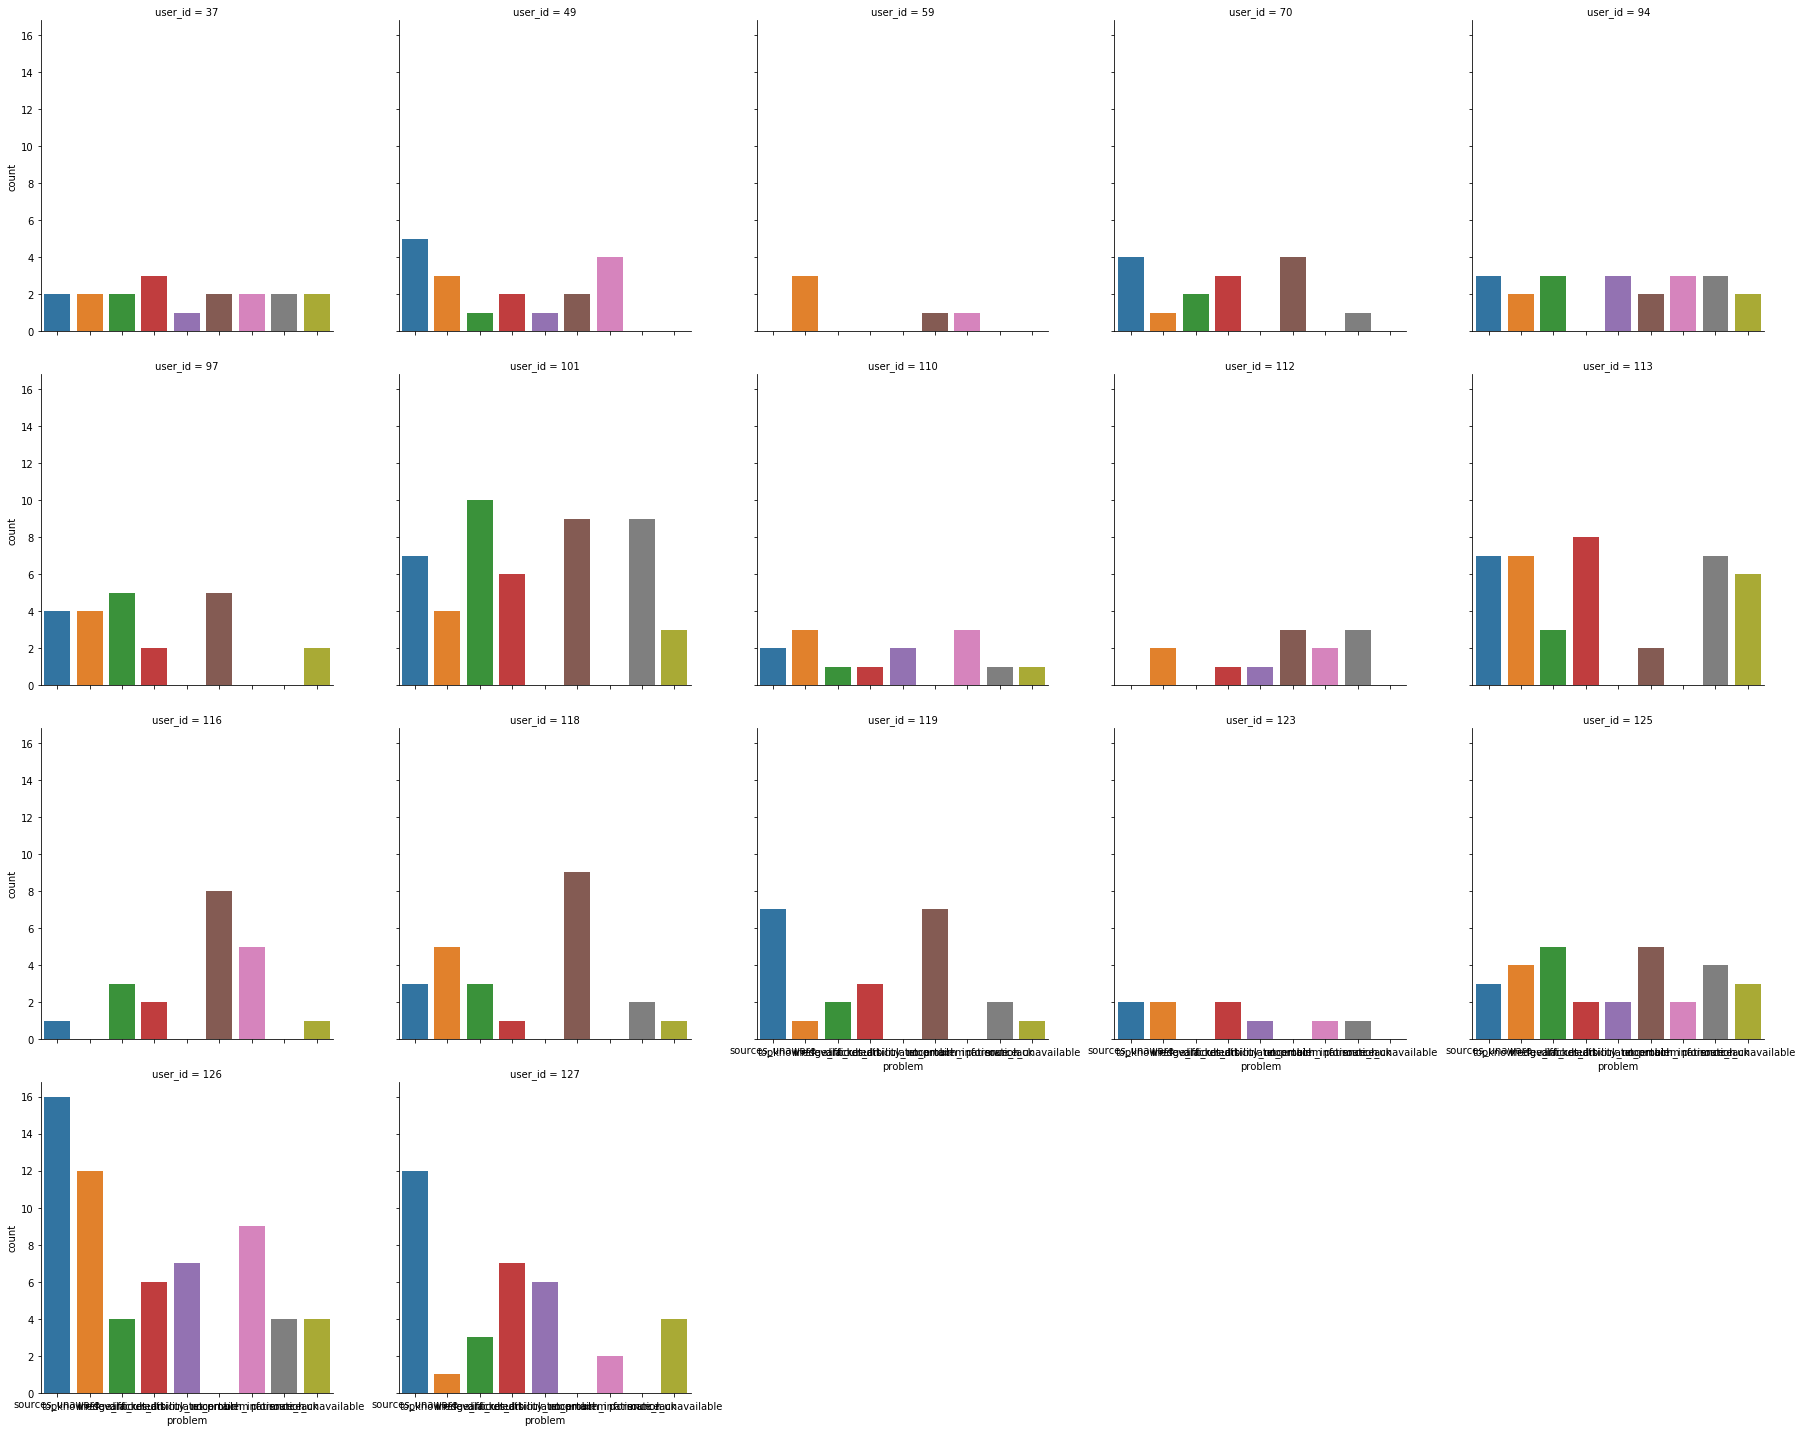

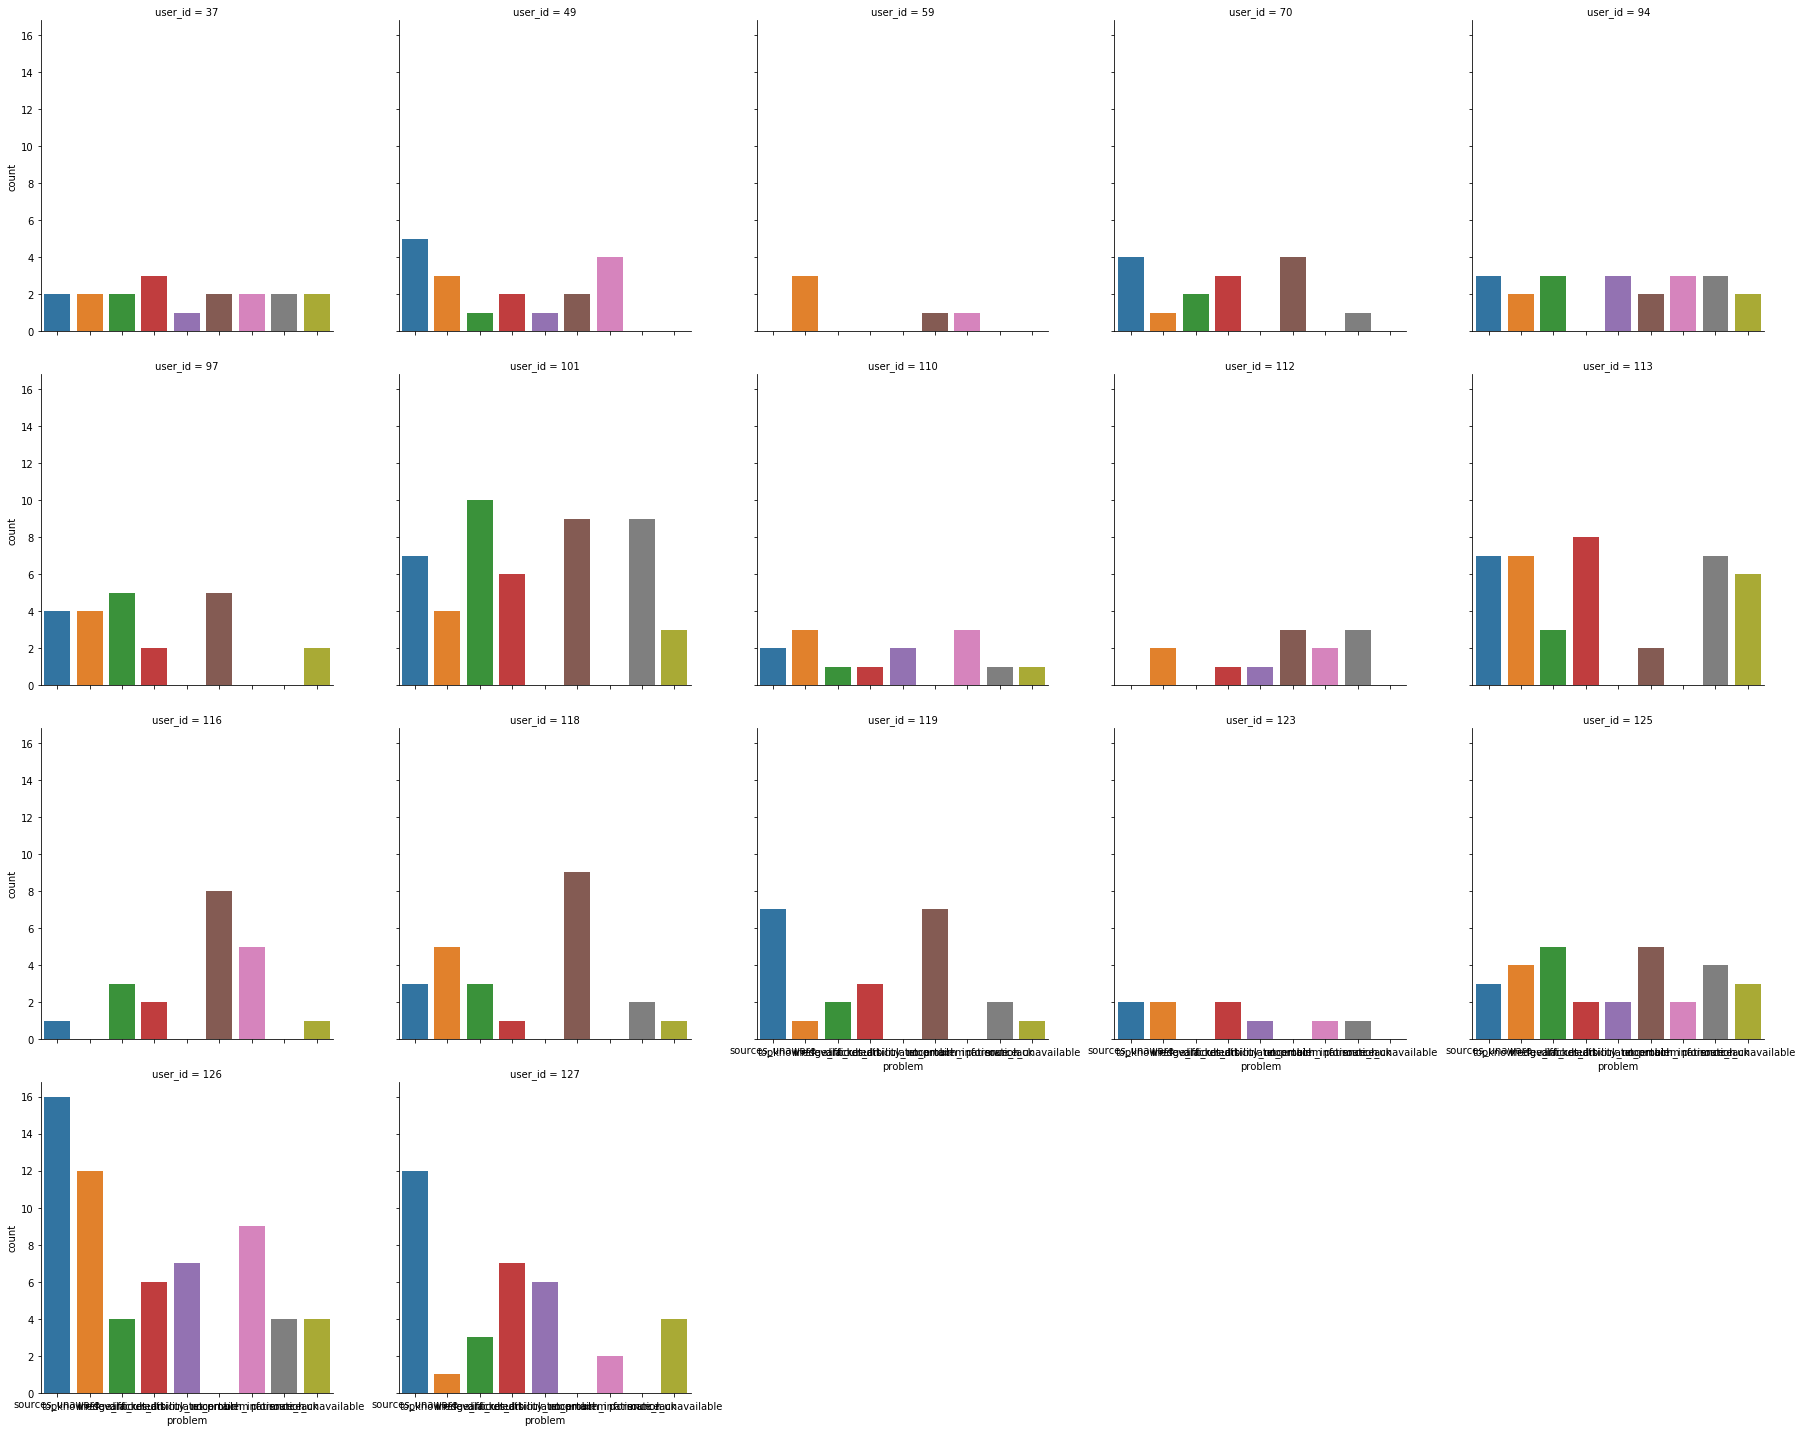

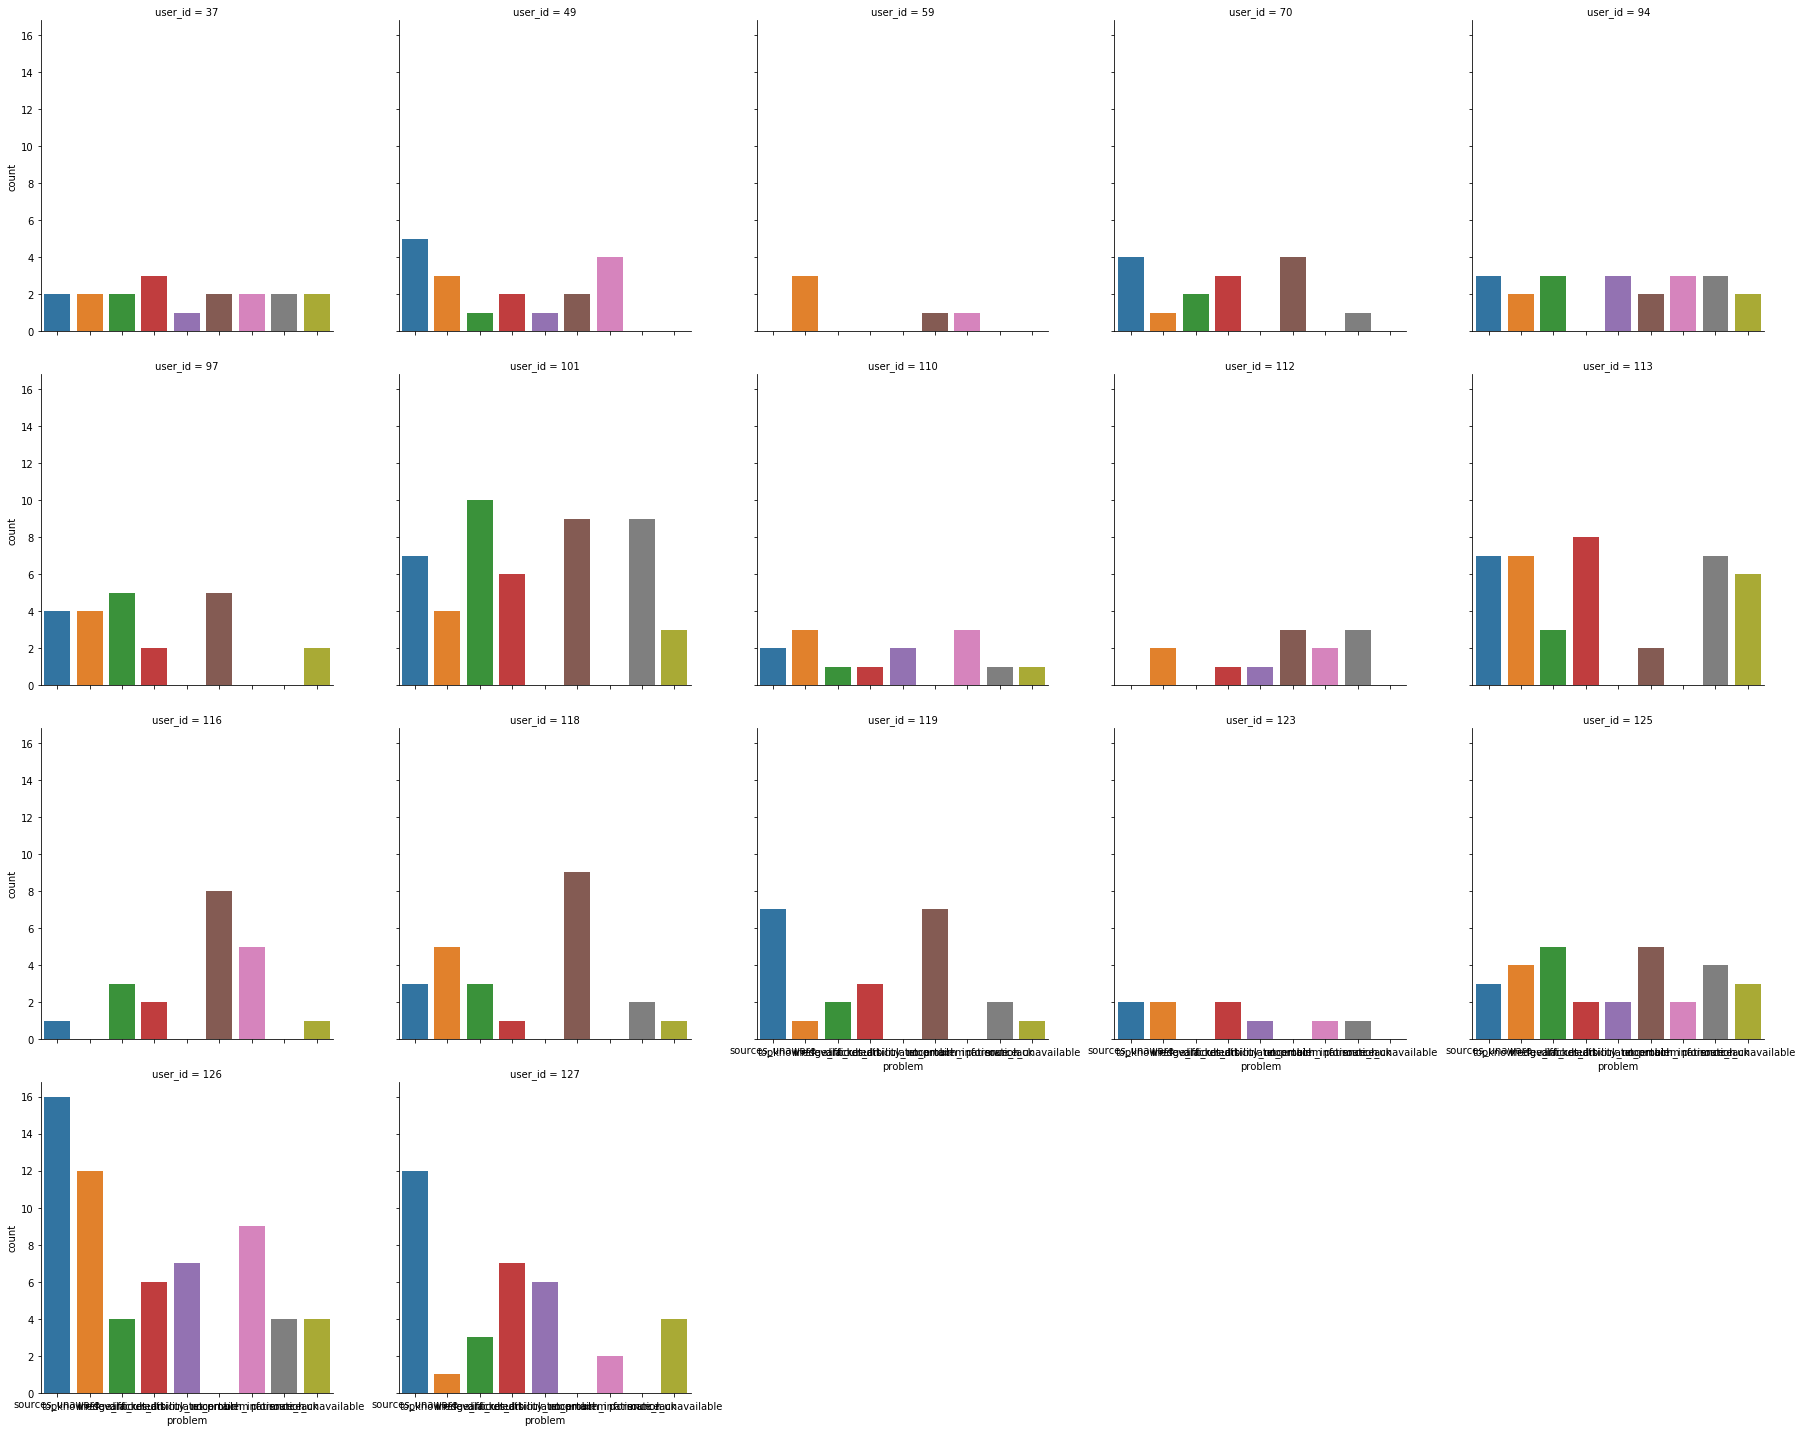

In [9]:
# RQ 4.1 - Do the problems experienced by users differ between users?

g = sns.catplot("problem", col="user_id", col_wrap=5, 
                data=problems_unpacked_df,
                kind="count") #, height=2.5, aspect=.8)
plt.show()
plt.clf()
#g = sns.FacetGrid(problemhelp_df, col="user_id", col_wrap=6)
#g = g.map(plt.plot, "solutions", "score", marker=".")

<Figure size 432x288 with 0 Axes>

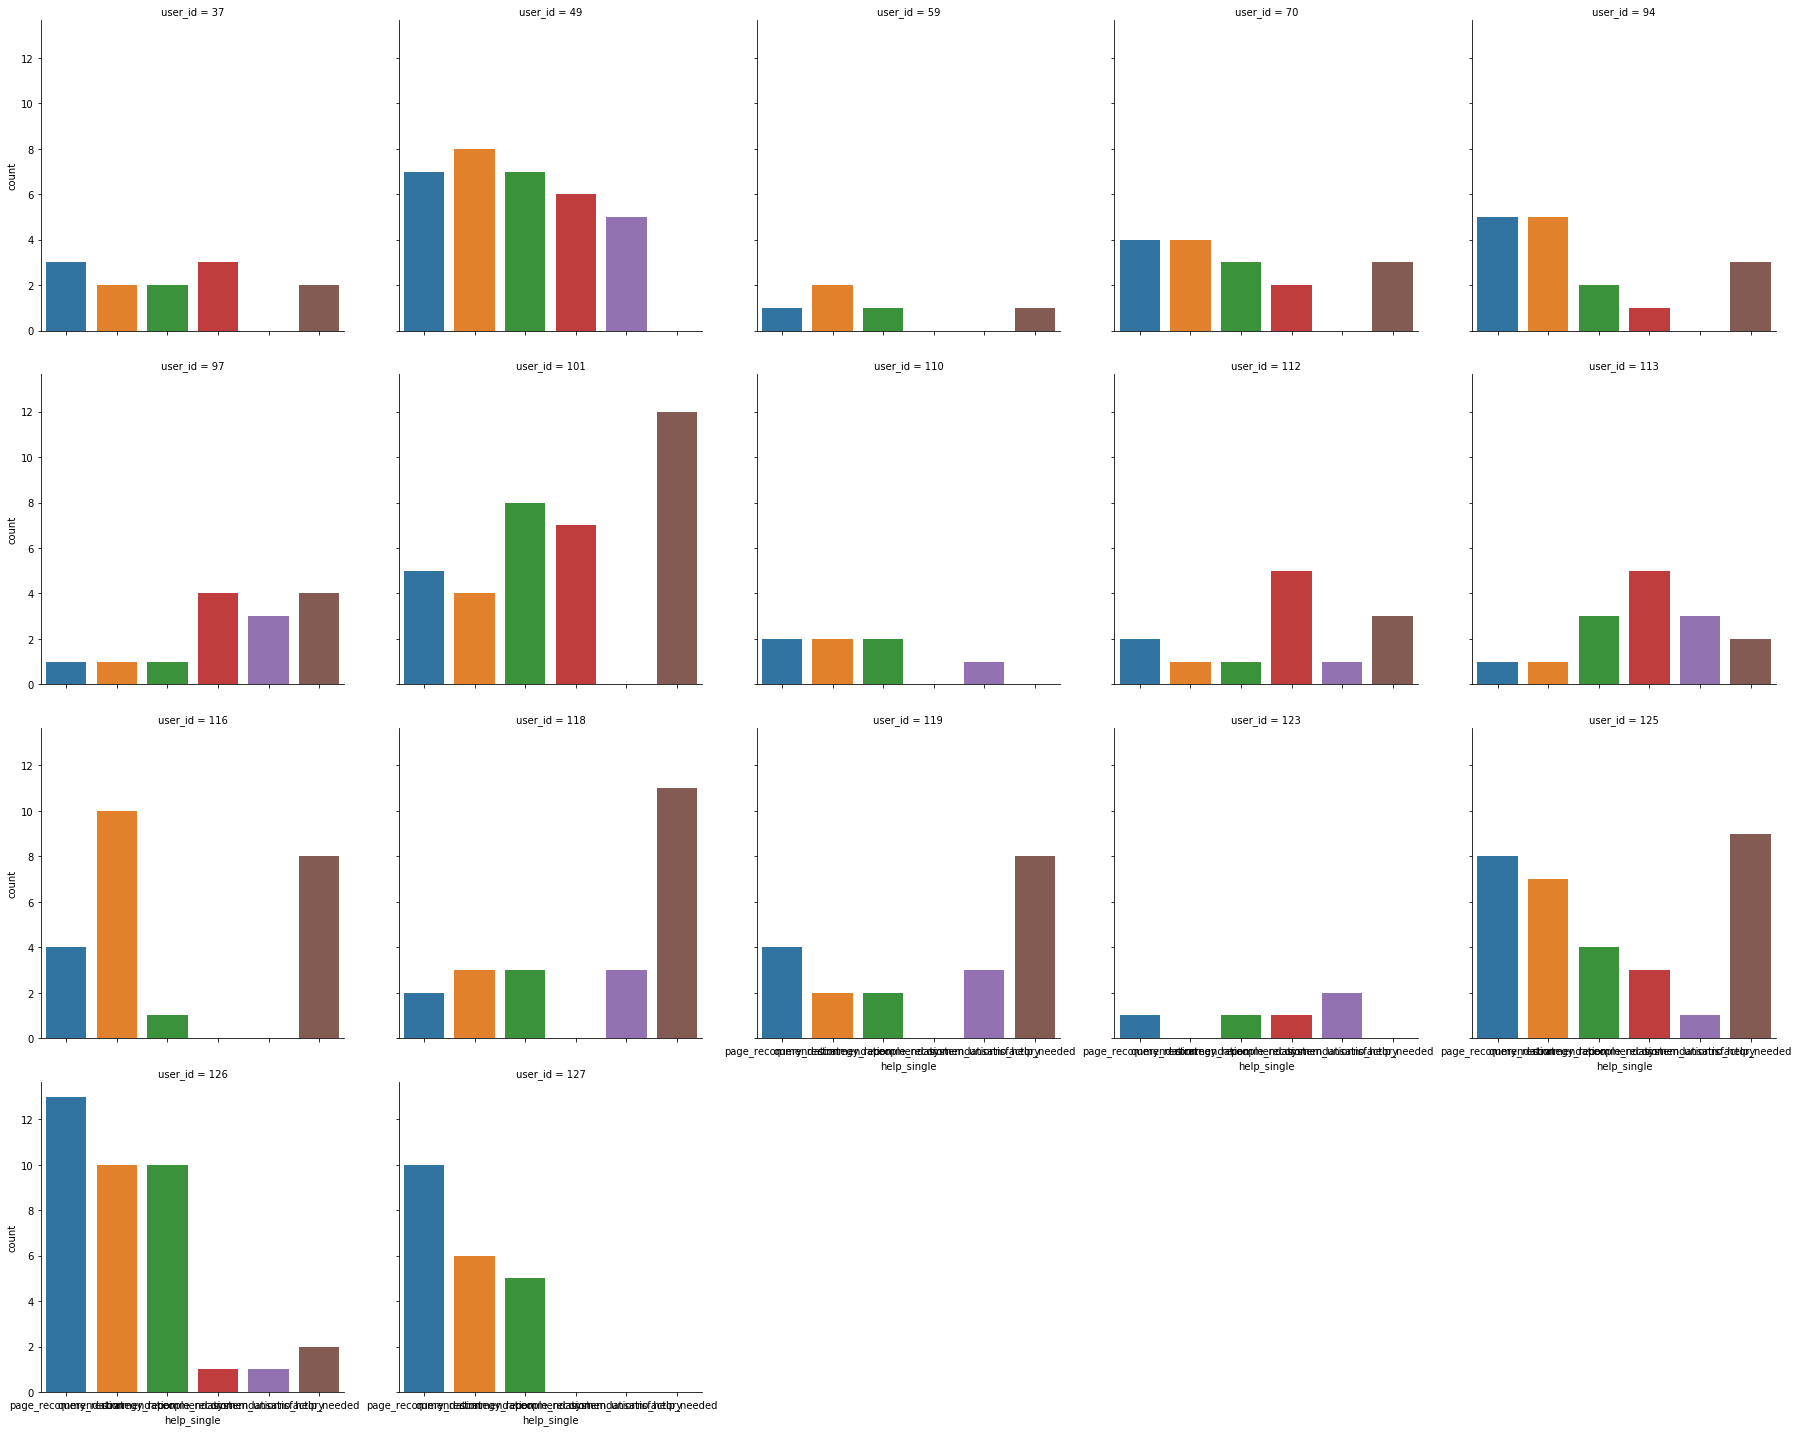

In [10]:
# RQ 4.2 - Do the helps required by users differ between users?

g = sns.catplot("help_single", col="user_id", col_wrap=5, 
                data=helps_unpacked_df,
                kind="count") #, height=2.5, aspect=.8)
plt.show()
plt.clf()
#g = sns.FacetGrid(problemhelp_df, col="user_id", col_wrap=6)
#g = g.map(plt.plot, "solutions", "score", marker=".")

In [ ]:
# RQ 5 - Do the problems experienced/help required by users differ between 
# user types (e.g., hi/lo topic familiarity)?

In [ ]:
# RQ 6 - To what extent do behaviors, problems experienced by users, and required help affect 
# users’ expectation disconfirmation?


# RQ 6.1 - To what extent are user behaviors, problems experienced by users, and required help 
# associated with their expectation disconfirmation states?

# RQ 6.2 - To what extent can we predict users’ expectation disconfirmation states from Web 
# search behavior?

In [11]:
# RQ 7 - What is the nature of the relationship between user characteristics, task characteristics, 
# behaviors, and the problems experienced by users?


In [ ]:
# RQ8 - To what extent can we predict the problems/help experienced by users at a given moment, 
# given our answers to RQ1-7?